In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import IsolationForest

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [6]:
data = pd.read_csv('kobe.csv')

In [7]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [8]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [10]:
for f in data.columns:
    print(f, '-', data[f].unique())
    print('------------------')

action_type - ['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Driving Layup Shot' 'Reverse Layup Shot' 'Reverse Dunk Shot'
 'Slam Dunk Shot' 'Turnaround Jump Shot' 'Tip Shot' 'Running Hook Shot'
 'Alley Oop Dunk Shot' 'Dunk Shot' 'Alley Oop Layup shot'
 'Running Dunk Shot' 'Driving Finger Roll Shot' 'Running Layup Shot'
 'Finger Roll Shot' 'Fadeaway Jump Shot' 'Follow Up Dunk Shot' 'Hook Shot'
 'Turnaround Hook Shot' 'Running Tip Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Reverse Layup Shot'
 'Driving Finger Roll Layup Shot' 'Fadeaway Bank shot' 'Pullup Jump shot'
 'Finger Roll Layup Shot' 'Turnaround Fadeaway shot'
 'Driving Reverse Layup Shot' 'Driving Slam Dunk Shot'
 'Step Back Jump shot' 'Reverse Slam Dunk Shot' 'Turnaround Bank shot'
 'Running Finger Roll Layup Shot' 'Floating Jump shot'
 'Putback Slam Dunk Shot' 'Running Bank shot' 'Driving Bank shot'
 'Putba

### Описание полей
action_type - тип действия

combined_shot_type - комбинированный тип броска

game_event_id - идентификатор игрового события

game_id - идентификатор игры

lat - широта

loc_x - координата х

loc_y - координата у

lon - долгота

minutes_remaining - осталось минут

period - период

playoffs - плей-офф

season - сезон

seconds_remaining - осталось секунд

shot_distance - расстояние от броска

shot_made_flag (this is what you are predicting) - точность броска (целевая переменная)

shot_type - тип броска

shot_zone_area - площадь зоны броска

shot_zone_basic - основная зона броска

shot_zone_range - диапазон зоны броска

team_id - идентификатор команды

team_name - название команды

game_date - дата игры

matchup - матч

opponent - противник

shot_id - идентификатор броска

### 1. Data cleaning

In [11]:
# Исключаем строки, без значения целевой переменной
data_cl = data[data['shot_made_flag'].notna()]

In [12]:
# Т.к. team_id только принимает единственное значение - удаляем столбцы:  team_id, team_name, matchup
# (вместо matchup будем использовать opponent)
data_cl = data_cl.drop('team_id', axis=1)
data_cl = data_cl.drop('team_name', axis=1)
data_cl = data_cl.drop('matchup', axis=1)

In [13]:
# Также удалим остальные айдишники, они не несут смысловой нагрузки при прогнозировании 
# (game_event_id, game_id, shot_id)
data_cl = data_cl.drop('game_event_id', axis=1)
data_cl = data_cl.drop('game_id', axis=1)
data_cl = data_cl.drop('shot_id', axis=1)

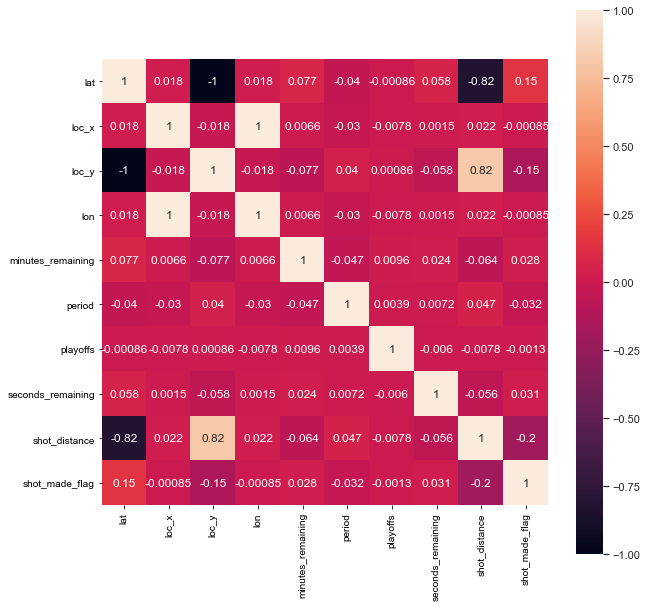

In [14]:
# Посмотрим, коррелируют ли остальные признаки между собой
corr = data_cl.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.set (font_scale = 1)
sns.heatmap(corr,annot=True,
                cbar = True,
                square=True,
           ax =ax)

In [15]:
# высокая корреляция признаков между собой у: loc_x и lon, lat и loc_y
data_cl = data_cl.drop('lon', axis=1)
data_cl = data_cl.drop('lat', axis=1)

### Feature Engineering

In [16]:
# сгенерируем новый признак - сколько осталось всего секунд до окончания матча
data_cl['time_remaining'] = data_cl['minutes_remaining'] * 60 + data_cl['seconds_remaining']
# у удалим minutes_remaining и seconds_remaining
data_cl = data_cl.drop('minutes_remaining', axis=1)
data_cl = data_cl.drop('seconds_remaining', axis=1)

In [17]:
# cгенерируем новые признаки год и месяц игры: 
data_cl['game_date_DT'] = pd.to_datetime(data_cl['game_date'])
data_cl['year'] = data_cl['game_date_DT'].dt.year
data_cl['month'] = data_cl['game_date_DT'].dt.month

In [18]:
# удалим game_date_DT
data_cl = data_cl.drop('game_date_DT', axis=1)
data_cl = data_cl.drop('game_date', axis=1)

In [19]:
import scipy.stats as ss

In [20]:
#используем Cramers V для поиска корреляции между категориальными переменными
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Строим перекрестную таблицу
    stat = ss.chi2_contingency(crosstab, correction=False)[0] # Chi2 статистика
    obs = np.sum(crosstab) # Считаем кол-во наблюдений
    mini = min(crosstab.shape)-1 # Берем минимальное значение
    return (stat/(obs*mini))
cramers_V(data_cl['action_type'], data_cl['combined_shot_type'])

1.0

In [21]:
#Корреляция между признаками action_type combined_shot_type - полная - поэтому один из признаков нужно будем удалить. 
#Так как action_type - более развернутый - оставим его.
#Если оставить combined_shot_type - снижает скор на 0.1!

In [22]:
data_cl = data_cl.drop('combined_shot_type', axis=1)

In [23]:
# Смотрим корреляцию между shot distance и shot zone ragne
cramers_V(data_cl['shot_distance'], data_cl['shot_zone_range'])

0.9613748823472985

In [24]:
#Также очень высока, оставляем  shot_zone_range (у shot_distance корреляция с loc_y)
data_cl = data_cl.drop('shot_distance', axis=1)

#### Outliers and One-Hot-Encoding

In [25]:
# сформируем перечень категориальных признаков
cat_feat = list(data_cl.dtypes[data_cl.dtypes == object].index)
# сформируем перечень категориальных переменных (уникальных значений 2):
paired_cat_feat = []
for f in cat_feat:
    if len(data_cl[f].unique()) == 2:
        paired_cat_feat.append(f)
        cat_feat.remove(f)
# сформируем перечень непрерывных признаков
num_feat = [f for f in data_cl if f not in (cat_feat+paired_cat_feat)]
num_feat.remove(target)

In [26]:
print('cat_feat:',cat_feat)
print('------------------')
print('paired_cat_feat:',paired_cat_feat)
print('------------------')
print('num_feat:',num_feat)

cat_feat: ['action_type', 'season', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent']
------------------
paired_cat_feat: ['shot_type']
------------------
num_feat: ['loc_x', 'loc_y', 'period', 'playoffs', 'time_remaining', 'year', 'month']


In [27]:
# убираем из num_feat порядковые категориальные переменные
num_feat.remove('playoffs')
num_feat.remove('period')
num_feat.remove('year')
num_feat.remove('month')

In [28]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

In [29]:
# def get_cat_categories(df, cat_columns):
#     categories = []
#     for column in cat_columns:
#         categories.append(list(df[column].unique()))    
#     return categories
# categories = get_cat_categories(data_cl, cat_feat)

In [30]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('paired_cat', OrdinalEncoder(),paired_cat_feat),# Делаем label encoding для категориальных переменных (уникальных значений 2)
#         ('cat', OneHotEncoder(categories=categories, sparse=False), cat_feat),# Делаем one-hot encoding для категориальных переменных (уникальных значений более 2)
#         ('num', StandardScaler(), num_feat) #Делаем стандартизацию для непрерывных переменных
#     ],
#     sparse_threshold=0,
#     remainder='drop'
# )

# C preprocessor не получилось, проблемы с LabelEncoder? делаю вручную

In [31]:
# Делаем label encoding для категориальных переменных (уникальных значений 2):
le = LabelEncoder()
for f in paired_cat_feat:
    data_cl[f] = le.fit_transform(data_cl[f].values)
    print(f + ' has been label encoded')

shot_type has been label encoded


In [32]:
# Делаем one-hot encoding для категориальных переменных (уникальных значений более 2):
for f in cat_feat:
    dummies = pd.get_dummies(data_cl[f])
    dummies = dummies.add_prefix("{}#".format(f))
    data_cl.drop(f, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)
    print(f + ' has been one hot encoded')

action_type has been one hot encoded
season has been one hot encoded
shot_zone_area has been one hot encoded
shot_zone_basic has been one hot encoded
shot_zone_range has been one hot encoded
opponent has been one hot encoded


In [33]:
# Для непрерывных признаков ищем выбросы:
# IQR метод
def iqr_outliers(data):
    """
    Определяем список выбросов для переменной
    """
    out = []
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in data:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    print("Outliers:",out)

def iqr_outliers_len(data):
    """
    Смотрим кол-во выбросов
    """
    out = []
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in data:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    return len(out)

def box_plots(data):
    """
    Отрисовываем box-plot для непрерывной переменной
    """
    plt.figure(figsize=(10, 4))
    plt.title("Box Plot")
    sns.boxplot(data)
    plt.show()
    
    
def drop_outliers(data, feature):
    """
    Удаляем выбросы через IQR*1.5
    """
    iqr = 1.5 * (np.percentile(data[feature], 75) - np.percentile(data[feature], 25))
    data.drop(data[data[feature] > (iqr + np.percentile(data[feature], 75))].index, inplace=True)
    data.drop(data[data[feature] < (np.percentile(data[feature], 25) - iqr)].index, inplace=True)
    
def Iso_outliers(data):
    """
    Изолирующий лес
    """
    iso_f = IsolationForest(random_state = 1, contamination= 'auto')
    preds = iso_f.fit_predict(data.values.reshape(-1,1))
    data_iso = pd.DataFrame()
    data_iso['cluster'] = preds
    print(data_iso['cluster'].value_counts().sort_values(ascending=False))

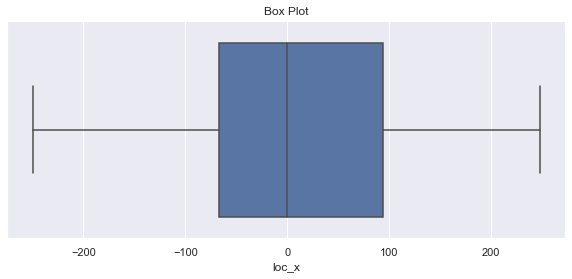

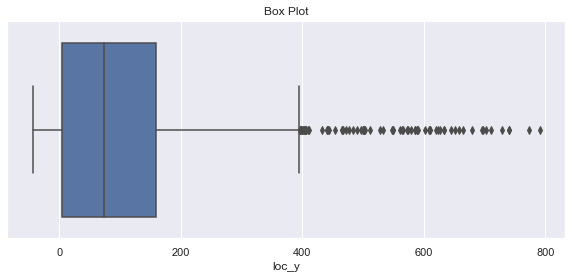

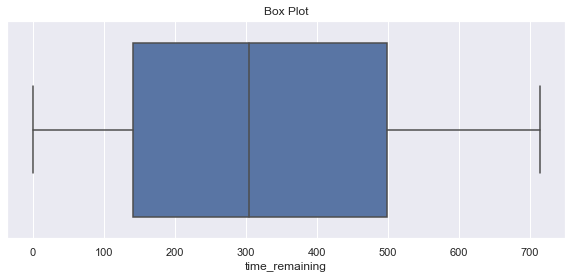

In [34]:
#Отрисуем бокс-плоты для непрерывных переменных
for f in num_feat:
    box_plots(data_cl[f])

In [35]:
# посмотрим, сможем ли найти выбросы 
f_out = ['loc_y', 'period', 'playoffs']
for f in f_out:
    print(f)
    print('Isolation forest:', Iso_outliers(data_cl[f]))
    print('IQR:', iqr_outliers_len(data_cl[f]))
    print('-------')

loc_y
 1    19410
-1     6287
Name: cluster, dtype: int64
Isolation forest: None
IQR: 76
-------
period
 1    13045
-1    12652
Name: cluster, dtype: int64
Isolation forest: None
IQR: 7
-------
playoffs
 1    21939
-1     3758
Name: cluster, dtype: int64
Isolation forest: None
IQR: 3758
-------


In [36]:
# визуально выбросы наблюдаются для полей loc_y, period, playoffs, shot_distance
# Для полей period и playoffs объяснимо тем, что только часть игр - это плей-офф и седьмой период - дополнительный, т.е. это норма, а не выброс
# Для полей loc_y, shot_distance - объяснимо неудобством некоторых точек для броска (нет смысла бросать издалека)
# отдетектированные выбросы удалять не вижу смысла

In [40]:
#создаем копию предобработанного датасета
data_f = data_cl.copy()
#делаем стандартизацию для непрерывных переменных
sc = data_f[num_feat]
scaler = StandardScaler().fit(sc.values)
sc = scaler.transform(sc.values)
data_f[num_feat] = sc
data_f.head()

,loc_x,loc_y,period,playoffs,shot_made_flag,shot_type,time_remaining,year,month,action_type#Alley Oop Dunk Shot,...,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS
1,-1.491296,-1.035246,1,0,0.0,0,1.442489,2000,10,0,...,0,0,1,0,0,0,0,0,0,0
2,-0.982533,0.496228,1,0,1.0,0,0.688794,2000,10,0,...,0,0,1,0,0,0,0,0,0,0
3,1.188792,0.949998,1,0,0.0,0,0.434362,2000,10,0,...,0,0,1,0,0,0,0,0,0,0
4,-0.064944,-1.035246,2,0,1.0,0,0.275942,2000,10,0,...,0,0,1,0,0,0,0,0,0,0
5,-1.382275,-1.160033,3,0,0.0,0,1.202459,2000,10,0,...,0,0,1,0,0,0,0,0,0,0


### Logistic regression

In [43]:
y = data_cl[target]
X = data_cl.drop(target, axis=1)

In [106]:
# по умолчанию стоит l2 - ставим none
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
log_model =  LogisticRegression(max_iter=1000,penalty='none',solver = 'saga')
log_model.fit(X, y)
y_pred = log_model.predict(X)
print('Accuracy' ,log_model.score(X, y))

Accuracy 0.6428376853329182


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [48]:
# Посмотрим, оценить важность признаков после преобразования
from sklearn.ensemble import RandomForestRegressor

clf_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=5, max_features=0.5, n_jobs=-1)
clf_rf.fit(X, y)

RandomForestRegressor(max_depth=5, max_features=0.5, min_samples_leaf=5,
                      n_estimators=10, n_jobs=-1)

In [49]:
imp = pd.Series(clf_rf.feature_importances_)
imp_values = imp.sort_values(ascending=False)
imp_values.head(10)

33     0.494971
34     0.199159
94     0.086323
1      0.030993
5      0.030034
6      0.024113
100    0.020911
54     0.018801
36     0.015342
0      0.012791
dtype: float64

In [109]:
# Ridge L2-регуляризация
from sklearn.linear_model import RidgeClassifier
model_ridge = LogisticRegression(penalty='l2',max_iter = 1000, solver = 'saga')
model_ridge.fit(X, y)
y_pred_r = model_ridge.predict(X)
print('Accuracy' ,model_ridge.score(X, y))

Accuracy 0.6427598552360198


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [105]:
#Lasso L1-регуляризация
lasso_model =  LogisticRegression(penalty='l1',solver = 'saga', max_iter = 1000) #работает только на saga или liblinear
lasso_model.fit(X, y)
y_pred_l = lasso_model.predict(X)
print('Accuracy' ,lasso_model.score(X, y))

Accuracy 0.6428376853329182


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [55]:
#Пробуем использовать elastic_net (комбинация l1 и l2 регуляризаций)
elastic_model =  LogisticRegression(penalty='elasticnet',solver = 'saga', max_iter = 1000, l1_ratio = 0.5) #работает только на saga или liblinear
elastic_model.fit(X, y)
y_pred_e = elastic_model.predict(X)
print('Accuracy' ,elastic_model.score(X, y))

Accuracy 0.6428376853329182


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [59]:
#Записываем  коэффициенты в датафрейм
models_coef = pd.DataFrame()
models_coef['Feature'] = pd.Series(list(X.columns))
models_coef['LogisticRegression'] = log_model.coef_[0]
models_coef['Lasso'] = lasso_model.coef_[0]
models_coef['Ridge'] = model_ridge.coef_[0]
models_coef['ElasticNet'] = elastic_model.coef_[0]

In [60]:
models_coef

,Feature,LogisticRegression,Lasso,Ridge,ElasticNet
0,loc_x,-0.000078,-0.000331,-0.000130,0.000057
1,loc_y,-0.001304,-0.000452,-0.000169,-0.001307
2,period,-0.067360,-0.056834,-0.023796,-0.044050
3,playoffs,-0.010207,-0.030689,-0.005620,-0.002883
4,shot_type,0.005916,0.174740,0.117341,-0.048281
...,...,...,...,...,...
129,opponent#SEA,0.069272,0.072022,0.044953,0.003059
130,opponent#TOR,-0.034753,-0.142628,-0.051130,0.001403
131,opponent#UTA,0.024444,0.026327,0.024226,0.000426
132,opponent#VAN,0.019678,0.077978,0.053100,0.000912


In [61]:
#вся таблица не влезает - поэтому расширим ее при помощи pd.set_option
pd.set_option('display.max_rows', None, 'display.max_columns', None)
models_coef

,Feature,LogisticRegression,Lasso,Ridge,ElasticNet
0,loc_x,-0.000078,-0.000331,-0.000130,5.660545e-05
1,loc_y,-0.001304,-0.000452,-0.000169,-1.306731e-03
2,period,-0.067360,-0.056834,-0.023796,-4.404970e-02
3,playoffs,-0.010207,-0.030689,-0.005620,-2.882725e-03
4,shot_type,0.005916,0.174740,0.117341,-4.828057e-02
5,time_remaining,0.000277,0.000277,0.000117,2.398968e-04
6,year,0.000446,0.000596,-0.030375,8.849645e-05
7,month,-0.002632,0.000666,-0.002761,-3.329872e-03
8,action_type#Alley Oop Dunk Shot,0.141278,1.550011,0.431267,1.489433e-02
9,action_type#Alley Oop Layup shot,0.021887,-0.150926,-0.026037,3.824400e-03


<Figure size 1080x2160 with 0 Axes>

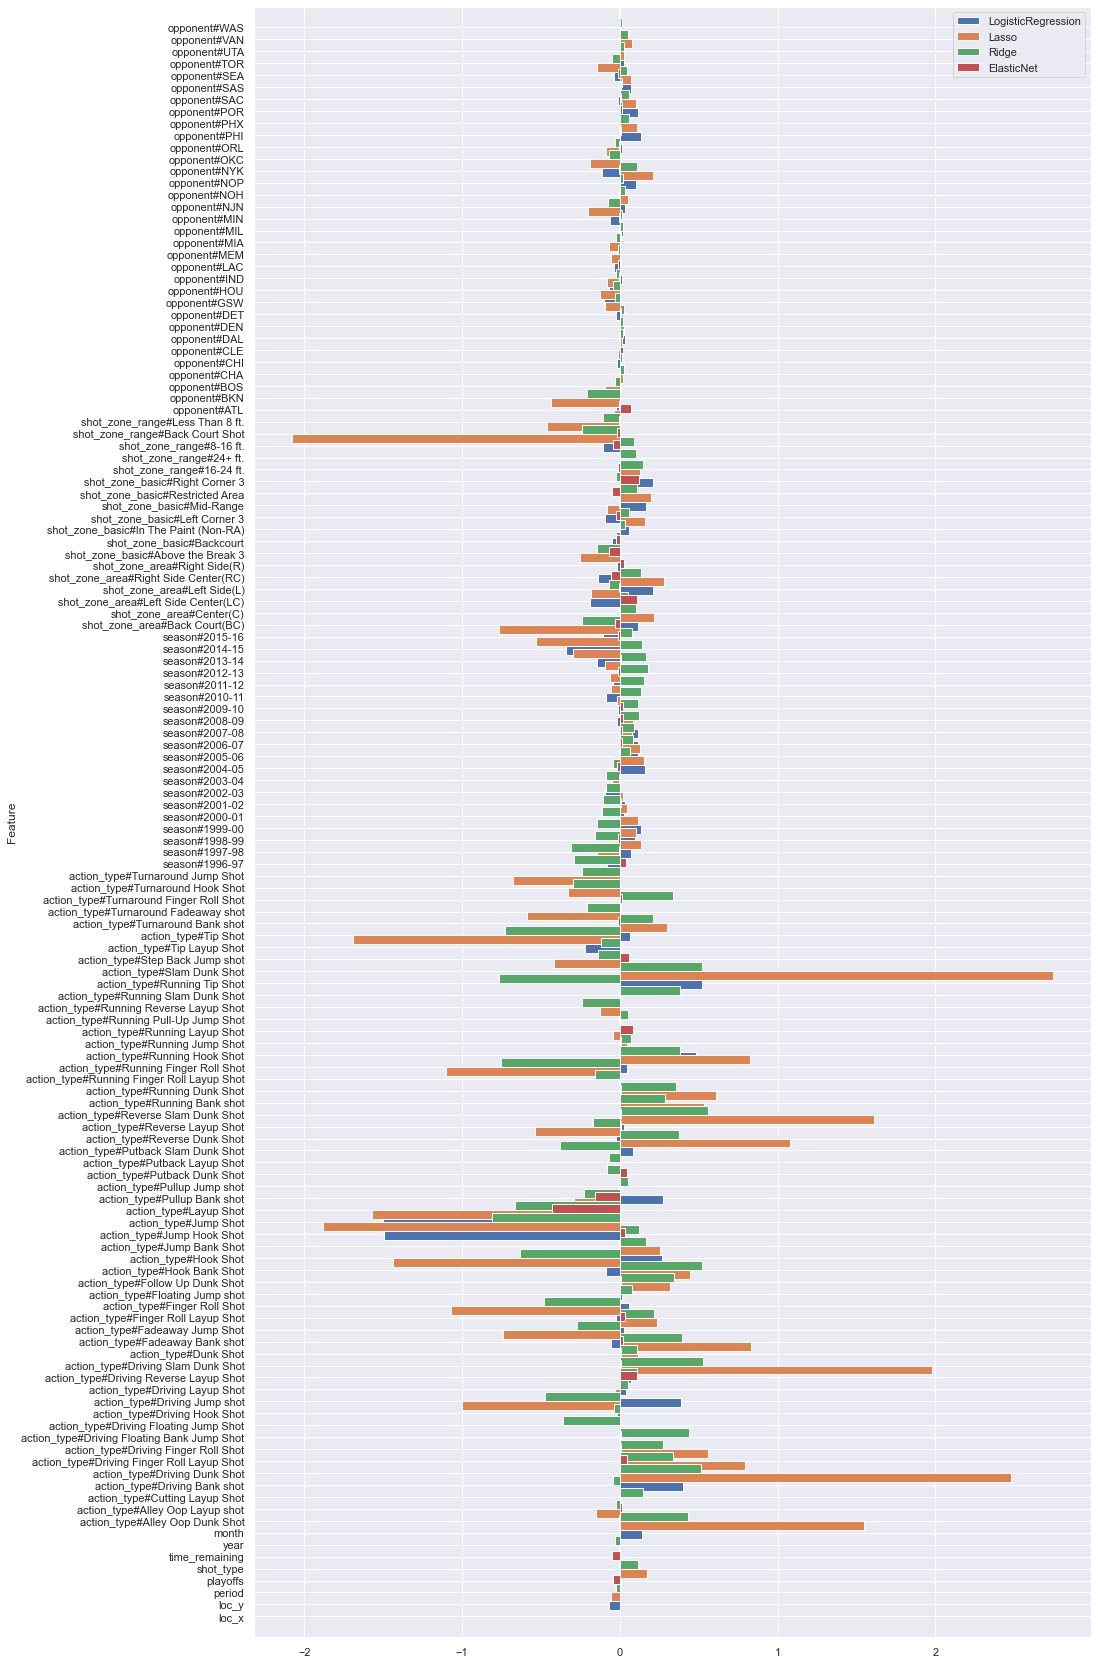

In [67]:
#на таблице не показательно, визуализируем коэффициенты
index = models_coef['Feature']
df = models_coef
plt.rcParams["figure.figsize"] = (15,30)
plt.tight_layout()
df.plot.barh(x='Feature', width=3)

In [69]:
# из гистограммы видно, что Lasso и ElasticNet занулила, либо значительно уменьшила влияние нескольких фичей,  
# обнулив некоторые из значений коэффициентов фичей opponent и season практически для Lasso и ElasticNet
# Ridge снижает мультиколлинеарность признаков, пытаясь уменьшить значение коэффициентов части признаков.

In [70]:
# разбиваем выборку на тестовую и обучающую
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
#Делаем стандартизацию 
sc_train = X_train[num_feat]
scaler_t = StandardScaler().fit(sc_train.values) #обучаем на трэйне
sc_train = scaler_t.transform(sc_train.values)
X_train[num_feat] = sc_train
sc_test = X_test[num_feat]
sc_test = scaler_t.transform(sc_test.values) #применяем к тесту
X_test[num_feat] = sc_test

<ipython-input-71-1237c109efef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_feat] = sc_train
C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-71-1237c109efef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [79]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

In [82]:
#зададим типы классификации (lasso, ridge, elasticnet, without regularization)
penalties = ['l1', 'l2', 'elasticnet', 'none']
results = {}

In [108]:
#запускаем лог регрессию для всех вариантов penalty
for penalty in penalties:
    if penalty == 'elasticnet':
        model = LogisticRegression(penalty = penalty, solver='saga',max_iter = 1000, l1_ratio = 0.5)
        model.fit(X_train,y_train)
        y_pred = model.predict_proba(X_test)[:,1]
        results[penalty] = y_pred
    elif penalty == 'l1':
        model = LogisticRegression(penalty = penalty, solver='saga',max_iter = 1000)
        model.fit(X_train,y_train)
        y_pred = model.predict_proba(X_test)[:,1]
        results[penalty] = y_pred
    else:
        model = LogisticRegression(penalty = penalty,max_iter = 1000)
        model.fit(X_train,y_train)
        y_pred = model.predict_proba(X_test)[:,1]
        results[penalty] = y_pred

C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [110]:
results

{'l1': array([0.5190774 , 0.32585456, 0.34038872, ..., 0.36442433, 0.37617642,
        0.65697145]),
 'l2': array([0.74779447, 0.32867729, 0.33709565, ..., 0.34451418, 0.37373428,
        0.77445456]),
 'elasticnet': array([0.51921071, 0.32583769, 0.34039292, ..., 0.36448889, 0.37617998,
        0.65719988]),
 'none': array([0.68988092, 0.33652553, 0.36762635, ..., 0.33698023, 0.38203667,
        0.79672709])}

In [111]:
score

{'l1': 0.6567708113226384,
 'l2': 0.6568116937960923,
 'elasticnet': 0.6567842856959116,
 'none': 0.6568121531497266}

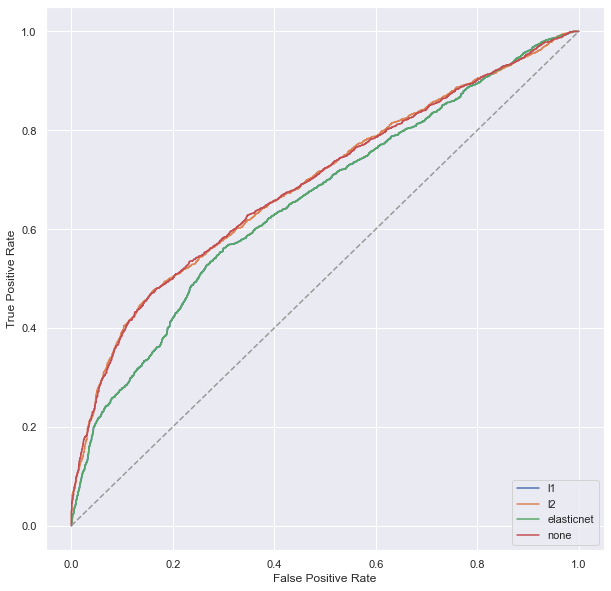

In [112]:
score = {}
plt.figure(figsize=(10, 10))
for (penalty), value in results.items():
    score[penalty] = roc_auc_score( y_test, value )
    fpr, tpr, thres = roc_curve(y_test, value)
    plt.plot( fpr, tpr, label = f'{penalty}')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [121]:
#Elastic_net показал наиболее низкие результаты, 
# но из оставшихся трех моделей выбрать наилучшую однозначно нельзя,score также практически одинаков
# Найдем, какой вариант регресии наиболее оптимален (самая большая площадь под кривой)
{x: y for x, y in filter(lambda x: score[x[0]] == max(score.values()), score.items())}

{'l2': 0.690905533006396}

In [ ]:
#ridge паказал наилучший результат

In [122]:
# пробуем сжать признаки
N = len(list(X.columns)) #кол-во признаков
from sklearn.decomposition import PCA
pca = PCA(n_components = N)
pca.fit(X)

PCA(n_components=134)

In [123]:
for i in range(1, N):
    print(f'components: {i}, explained variance ratio: {sum(pca.explained_variance_ratio_[:i])}')

components: 1, explained variance ratio: 0.6862387236048099
components: 2, explained variance ratio: 0.8776489294425187
components: 3, explained variance ratio: 0.9992729847141459
components: 4, explained variance ratio: 0.9996385667080986
components: 5, explained variance ratio: 0.9999107476478529
components: 6, explained variance ratio: 0.9999316380264959
components: 7, explained variance ratio: 0.9999435435103877
components: 8, explained variance ratio: 0.9999499654346826
components: 9, explained variance ratio: 0.999954625246411
components: 10, explained variance ratio: 0.9999572625259971
components: 11, explained variance ratio: 0.999959465068223
components: 12, explained variance ratio: 0.9999616078370134
components: 13, explained variance ratio: 0.9999632122523943
components: 14, explained variance ratio: 0.9999644270880369
components: 15, explained variance ratio: 0.9999656103752106
components: 16, explained variance ratio: 0.9999667800809863
components: 17, explained variance 

In [120]:
#Оставляем первых 7 признаков, они объясняют более 99% модели

In [162]:
# При помощи PCA убрали мультиколлинеарность, поэтому используем просто обычную логистическую регрессию
from sklearn.decomposition   import PCA
pca_model = PCA(n_components=7)
pca_model.fit(X_train)
pca_data_train = pca_model.transform(X_train)
pca_data_test = pca_model.transform(X_test)

lr_model = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

y_predict = lr_model.predict(X_test)

In [163]:
print('Accuracy' ,lr_model.score(X_test, y_test))

Accuracy 0.6760700389105059


In [ ]:
#Сжатие признаков не увеличило скор, в принципе это объяснимо, так как в признаках много категориальных признаков